In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from tqdm.auto import tqdm
plt.style.use('ggplot')

from pylab import rcParams

rcParams["figure.figsize"] = 10, 6

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Сформулируем гипотезы:

Нулевая гипотеза $H_0:$ Разница между средними значениями двух исследуемых групп равна 0; 

Альтернативная гипотеза $H_1:$ Разница между средними значениями двух исследуемых групп не равна 0.

In [59]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')

In [60]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
# изменим разделитель в столбце value
df['value'] = df['value'].apply(lambda x: x.replace(',', '.'))

In [5]:
df = df[['value', 'experimentVariant']]

In [6]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [7]:
# изменим тип данных по столбцу value

In [8]:
df = df.astype({'value' : 'float'})

In [9]:
# разделим данные на два датасета

In [10]:
df_test = df.query("experimentVariant == 'Treatment'")

In [11]:
df_test.shape

(500, 2)

In [12]:
df_control = df.query("experimentVariant == 'Control'")

In [13]:
df_control.shape

(500, 2)

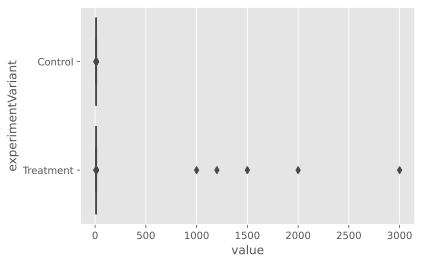

In [14]:
sns.boxplot(data=df, x='value', y='experimentVariant')

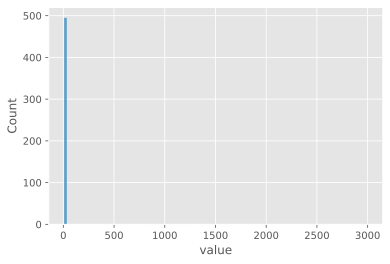

In [15]:
sns.histplot(data=df_test, x='value', bins=100)

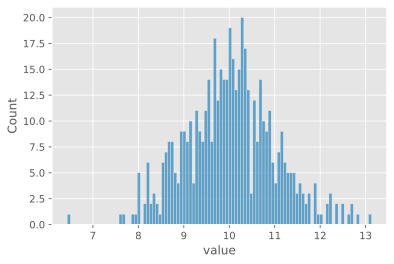

In [16]:
sns.histplot(data=df_control, x='value', bins=100)

Судя по графикам данные в тестовом распределении сильно смещены вправо, попробуем их прологарифмировать  

In [17]:
df_test['value_log'] = np.log(df_test.value)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_control['value_log'] = np.log(df_control.value)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


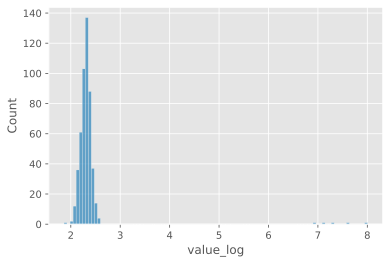

In [19]:
sns.histplot(data=df_test, x='value_log', bins=100)

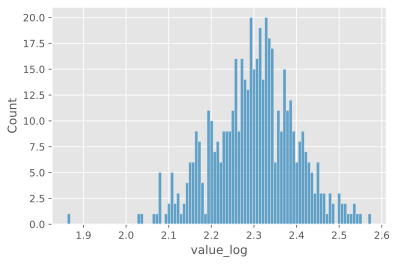

In [20]:
sns.histplot(data=df_control, x='value_log', bins=100)

Попытка прологарифмировать немного улучшила ситуацию в тестовой группе, но визуально распределение все еще смещено сильно вправо и имеются выбросы, попробуем их проанализировать 

In [21]:
df_test.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99])

,value,value_log
count,500.000000,500.000000
mean,27.321499,2.350802
std,186.557011,0.517151
min,6.436541,1.861991
1%,8.002168,2.079712
5%,8.446516,2.133754
10%,8.743006,2.168254
25%,9.421968,2.243044
50%,10.025847,2.305166
75%,10.675721,2.367972


In [22]:
df_control.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99])

,value,value_log
count,500.000000,500.000000
mean,10.026867,2.300469
std,0.979377,0.098422
min,6.436541,1.861991
1%,8.002168,2.079712
5%,8.446516,2.133754
10%,8.743006,2.168254
25%,9.411024,2.241882
50%,10.018465,2.304430
75%,10.664879,2.366956


В тестовой группе имеетсямаксимальное значение 3000, т.е между 99 перцентилем и максимумом произошел резкий скачок, попробуем посмотреть сколько таких значений и оценить насколько критично будет удалить такие выбросы/выброс

In [23]:
df_test.query("value > 23")

,value,experimentVariant,value_log
995,1000.0,Treatment,6.907755
996,1200.0,Treatment,7.090077
997,1500.0,Treatment,7.313220
998,2000.0,Treatment,7.600902
999,3000.0,Treatment,8.006368


Таких значений оказалось 5, это составляет 1% от общего количества значений тестовой группы, поэтому считаю можно пожертвовать этими значениями и удалить их 

In [24]:
df_test = df_test.query("value < 23")

In [25]:
df_test.shape

(495, 3)

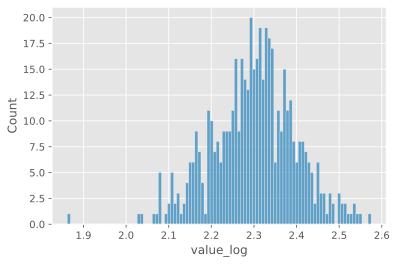

In [26]:
# теперь посмотрим как изменился характер распределения 
sns.histplot(data=df_test, x='value_log', bins=100)

In [27]:
# протестируем получившиеся распределения на нормальность 

In [28]:
pg.normality(data=df_test, dv="value", group="experimentVariant", method="normaltest")

,W,pval,normal
Treatment,3.426451,0.180283,True


In [29]:
pg.normality(data=df_control, dv="value", group="experimentVariant", method="normaltest")

,W,pval,normal
Control,2.943459,0.229528,True


In [30]:
# посмотрим на средние значения визуально
df_test.value.mean()

10.021716218850079

In [31]:
df_control.value.mean()

10.026866533804297

In [32]:
# Теперь применим t-test
ss.ttest_ind(df_test.value,
         df_control.value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

По подсчетам мы видим, что средние отличаются, но эти различия могут быть обусловлены законами природы или рандомным шумом. Для этого мы применили статистический тест стьюдента, который сравнил два средних значения по выборке и pvalue оказался равен 0.93 из этого следует, что мы не можем подтвердить гипотезу, что средние значения показателя value различаются в двух группах

In [33]:
df_2 = pd.read_csv('hw_bootstrap.csv', sep=';')

In [34]:
df_2['value'] = df_2['value'].apply(lambda x: x.replace(',', '.'))

In [35]:
df_2 = df_2.astype({'value' : 'float'})

In [36]:
df_test_2 = df_2.query("experimentVariant == 'Treatment'").value

In [37]:
df_control_2 = df_2.query("experimentVariant == 'Control'").value

In [38]:
# Теперь применим U-тест, сначала передадим данные с выбросами
ss.mannwhitneyu(df_control_2, df_test_2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [39]:
# Теперь посмотрим без выбросов 
ss.mannwhitneyu(df_control.value, df_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

Действительно U-тест не так сильно реагирует на выбросы, так как первый раз в него переданы данные, в которых в тестовой группе были выбросы, второй раз переданы обработанные данные из предыдущего шага. В обоих случаях при сравнении двух групп pvalue оказался больше 0.05 и из этого следует, что значимых различий между рангами групп нет

In [40]:
df_3 = pd.read_csv('hw_bootstrap.csv', sep=';')

In [41]:
df_3['value'] = df_3['value'].apply(lambda x: x.replace(',', '.'))

In [50]:
df_3 = df_3.astype({'value' : 'float'})

In [43]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [53]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 100, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

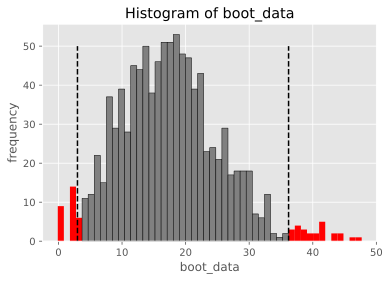

{'boot_data': [30.005716520108855,
  2.850571233947379,
  10.792925980227052,
  22.832060650055702,
  23.72763528462871,
  16.323166059973047,
  16.02288431818436,
  38.74344934975084,
  20.89860996231369,
  25.86452733890814,
  15.207941232065325,
  14.002234811736173,
  18.716521867891494,
  13.752745164073943,
  22.028797720157876,
  20.299504043287556,
  35.40697114062662,
  13.905237073003196,
  12.689192798683308,
  13.400960394780535,
  18.240068692873603,
  15.400413866327197,
  10.210275028215326,
  12.739213917882692,
  15.388566644954008,
  14.80223357472923,
  9.420482329929808,
  20.330746464576677,
  14.048609206977654,
  13.668297691843765,
  22.929980439954765,
  32.24999088026481,
  8.097086856687158,
  30.90586860088645,
  27.925282278603888,
  16.87888669531725,
  6.7667939713732626,
  12.969873442916976,
  6.407237882476597,
  14.323932107755471,
  22.092106302466398,
  23.663196948095603,
  14.116663629118134,
  36.34411418854704,
  4.352588893986937,
  17.37673982

In [55]:
get_bootstrap(
    df_3[df_3.experimentVariant == 'Treatment'].value,
    df_3[df_3.experimentVariant == 'Control'].value,
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95
)

Полученный доверительный интервал для средних значени не включает в себя 0, а pvalue равен 0.03, это означает, что средние между двумя группами значимо различаются и в данном случае принимаем альтернативную гипотезу. 

## Выводы:

1. Для применения t критерия должны быть соблюдены условия нормальности распределения и равенства дисперсий. В нашем случае, чтобы применить t критерий пришлось распределение тестовой группы приводить к нормальному, так как 5 выбросов смещали его сильно влево. Подготовка данных может занять некоторое время
2. U критерий менее чувствителен к экстримальным значениям, однако его результаты довольно сложно интепретировать, так как он сравнивает не сами средние значения, а их ранги
3. Bootstrap позволяет строить доверительный интервал и проверять гипотезы для любого параметра распределения (среднее, медиана и т.д.). Важно не забывать про качество исходных данных, с которыми работает бутстреп. Если эти данные нерепрезентативны и плохо отражают реальное состояние, то достоверных результатов ожидать не стоит